# PU rejection BDT

In [1]:
import os
import time
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import xgboost as xgb
import matplotlib
import pickle
from sklearn import metrics
from sklearn.model_selection import train_test_split
import matplotlib.lines as mlines
from scipy.optimize import curve_fit
from scipy.special import btdtri # beta quantile function
from bayes_opt import BayesianOptimization
from bayes_opt import SequentialDomainReductionTransformer

In [2]:
def prepareCat(row):
    if row['cl3d_isbestmatch'] == True and row['gentau_decayMode']>=0:
        return 1
    else:
        return 0

In [3]:
indir = '/home/llr/cms/motta/HGCAL/CMSSW_11_1_0/src/GRAPHAnalysis/L1BDT_redCalib/hdf5dataframes/calibrated'

FE = 'threshold'

inFileTraining_dict = {
    'threshold'    : indir+'/Training_PU200_th_calibrated.hdf5',
    'mixed'        : indir+'/'
}

# features for BDT training
#features = ['cl3d_c2', 'cl3d_abseta', 'cl3d_showerlength','cl3d_coreshowerlength', 'cl3d_firstlayer', 'cl3d_maxlayer', 'cl3d_szz', 'cl3d_seetot', 'cl3d_spptot', 'cl3d_srrtot', 'cl3d_srrmean', 'cl3d_hoe', 'cl3d_meanz', 'cl3d_layer10', 'cl3d_layer50', 'cl3d_layer90', 'cl3d_ntc67', 'cl3d_ntc90']
features = ['cl3d_c2', 'cl3d_pt_c2', 'cl3d_ntc90', 'cl3d_abseta']
output = 'gentau_pid'

In [4]:
store_tr = pd.HDFStore(inFileTraining_dict[FE], mode='r')
dfTraining = store_tr[FE]
store_tr.close()

dfTraining['gentau_pid'] = dfTraining.apply(lambda row: prepareCat(row), axis=1)
dfTr = dfTraining.query('gentau_pid==1 or (gentau_pid==0 and gentau_decayMode!=-2)').copy(deep=True) # take all the taus and all the PU not coming from QCD sample

del dfTraining

In [6]:
def train_xgb(dfTr, features, output, hyperparams, num_trees):
    X_train, X_test, y_train, y_test = train_test_split(dfTr[features], dfTr[output], stratify=dfTr[output], test_size=0.3)
    train = xgb.DMatrix(data=X_train,label=y_train, feature_names=features)
    test = xgb.DMatrix(data=X_test,label=y_test,feature_names=features)
    
    booster = xgb.train(hyperparams, train, num_boost_round=num_trees)
    X_train['bdt_output'] = booster.predict(train)
    fpr_train, tpr_train, threshold_train = metrics.roc_curve(y_train, X_train['bdt_output'])
    X_test['bdt_output'] = booster.predict(test)
    fpr_test, tpr_test, threshold_test = metrics.roc_curve(y_test, X_test['bdt_output'])

    auroc_test = metrics.roc_auc_score(y_test,X_test['bdt_output'])
    auroc_train = metrics.roc_auc_score(y_train,X_train['bdt_output'])

    return booster, fpr_train, tpr_train, threshold_train, fpr_test, tpr_test, threshold_test, auroc_test, auroc_train

In [17]:
params_dict = {}
params_dict['eval_metric']        = 'logloss'
params_dict['nthread']            = 10   # limit number of threads
params_dict['eta']                = 0.1626204851326839 # learning rate
params_dict['max_depth']          = 4    # maximum depth of a tree
params_dict['subsample']          = 0.7444555479702324 # fraction of events to train tree on
params_dict['colsample_bytree']   = 0.5932858214289836 # fraction of features to train tree on
params_dict['objective']          = 'binary:logistic' # objective function
params_dict['alpha']              = 0.01
params_dict['lambda']             = 0.7449325766805394

num_trees = 97  # number of trees to make

In [18]:
model, fpr_train, tpr_train, threshold_train, fpr_test, tpr_test, threshold_test, testAuroc, trainAuroc = train_xgb(dfTr, features, output, params_dict, num_trees)

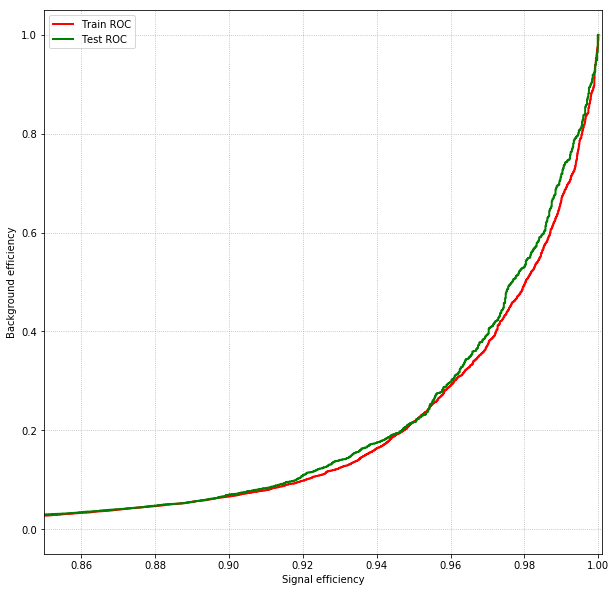

In [19]:
plt.figure(figsize=(10,10))
plt.plot(tpr_train,fpr_train,label='Train ROC', color='red',lw=2)
plt.plot(tpr_test,fpr_test,label='Test ROC', color='green',lw=2)
plt.grid(linestyle=':')
plt.legend(loc = 'upper left')
plt.xlim(0.85,1.001)
#plt.yscale('log')
#plt.ylim(0.01,1)
plt.xlabel('Signal efficiency')
plt.ylabel('Background efficiency')
plt.show()
plt.close()

In [23]:
print(testAuroc)
print(trainAuroc)
print(testAuroc-10*abs(trainAuroc-testAuroc))

0.961153416231591
0.9633639633251346
0.9390479452961548


In [21]:
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/opt/exp_soft/llr/python/3.7.0/el7/bin/python3.7 -m pip install --upgrade pip' command.
